Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
# !pip install tensorflow

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("CNN_assignment/dataset/Train")
data_dir_test = pathlib.Path("CNN_assignment/dataset/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_width, img_height),  # Resize all images to 150x150 (can be changed)
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,  # Shuffle the images
    seed =123
)

Found 6739 files belonging to 9 classes.


In [8]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_width, img_height),  # Resize all images to 150x150 (can be changed)
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,  # Shuffle the images
    seed =123
)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

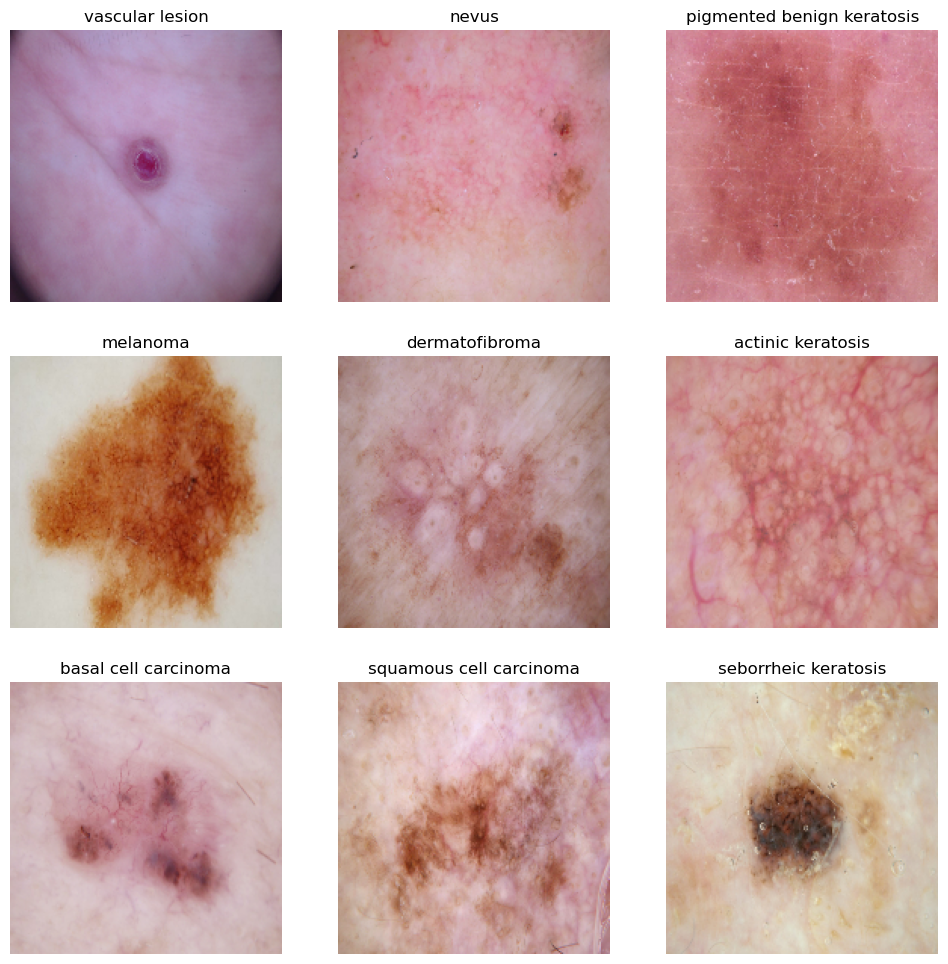

In [11]:
import matplotlib.pyplot as plt
# Function to plot one image from each class
def plot_one_image_per_class(dataset, class_names):
    plt.figure(figsize=(12, 12))
    # Initialize a counter to keep track of displayed classes
    displayed_classes = set()

    for images, labels in dataset:
        for i in range(len(images)):
            # Get the label index for this image
            label_index = tf.argmax(labels[i]).numpy()

            # Get the corresponding class name
            class_name = class_names[label_index]

            # Check if this class has already been displayed
            if class_name not in displayed_classes:
                ax = plt.subplot(3, 3, len(displayed_classes) + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_name)
                plt.axis("off")
                displayed_classes.add(class_name)

            # Stop once we have displayed one image per class
            if len(displayed_classes) == len(class_names):
                break

        if len(displayed_classes) == len(class_names):
            break

    plt.show()

# Visualize one instance of each class
plot_one_image_per_class(train_ds, class_names)



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
from tensorflow.keras import layers, models

# Normalize pixel values to be in the range [0, 1]
normalization_layer = layers.Rescaling(1./255)

# Apply the normalization layer to the datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Define the CNN model
model =keras.Sequential([
    keras.Input(shape=(180, 180, 3)),
    keras.layers.Conv2D(filters=32, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(9, activation="softmax")
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      10,617,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,010,377 (42.00 MB)

 Trainable params: 11,010,377 (42.00 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - categorical_accuracy: 0.2246 - loss: 2.8180 - val_categorical_accuracy: 0.2627 - val_loss: 2.1317
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - categorical_accuracy: 0.4504 - loss: 1.5852 - val_categorical_accuracy: 0.3220 - val_loss: 1.9842
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - categorical_accuracy: 0.4890 - loss: 1.4872 - val_categorical_accuracy: 0.3559 - val_loss: 1.9200
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - categorical_accuracy: 0.4933 - loss: 1.3969 - val_categorical_accuracy: 0.2966 - val_loss: 2.1533
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - categorical_accuracy: 0.5032 - loss: 1.3993 - val_categorical_accuracy: 0.4407 - val_loss: 1.9744
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - categorical_accuracy: 0.5075 - loss: 1.3454 - val_categorical_accuracy: 0.3051 - val_loss: 2.4411
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - categorical_accuracy: 0.5494 - loss: 1.312

### Visualizing training results

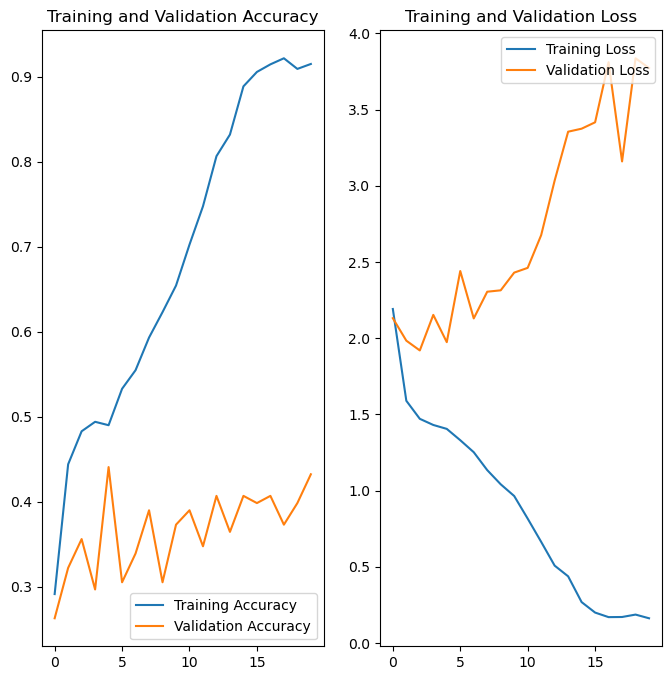

In [17]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Model is overfitting because model has higher accuracies on training data but failing on test data

### Write your findings here

The model might be overfitting to the training data (though this doesn't seem to be the case given the low accuracy).

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
# Adjust the augmentation parameters based on the model's performance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
import keras_cv


### Todo:
### Create the model, compile and train the model


In [20]:
model =keras.Sequential([
    keras.Input(shape=(180, 180, 3)),
    keras.layers.Conv2D(filters=32, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(9, activation="softmax")
])

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      10,617,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,010,377 (42.00 MB)

 Trainable params: 11,010,377 (42.00 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [22]:
## Your code goes here
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)


### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - categorical_accuracy: 0.2389 - loss: 2.9501 - val_categorical_accuracy: 0.2458 - val_loss: 2.1665
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - categorical_accuracy: 0.4111 - loss: 1.6538 - val_categorical_accuracy: 0.3051 - val_loss: 2.2933
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - categorical_accuracy: 0.4643 - loss: 1.5613 - val_categorical_accuracy: 0.3305 - val_loss: 2.3133
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - categorical_accuracy: 0.4872 - loss: 1.4347 - val_categorical_accuracy: 0.3898 - val_loss: 1.9747
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - categorical_accuracy: 0.4973 - loss: 1.4213 - val_categorical_accuracy: 0.3305 - val_loss: 2.1348
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - categorical_accuracy: 0.4863 - loss: 1.4199 - val_categorical_accuracy: 0.3729 - val_loss: 1.9677
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - categorical_accuracy: 0.5480 - loss: 1.2707 - 

### Visualizing the results

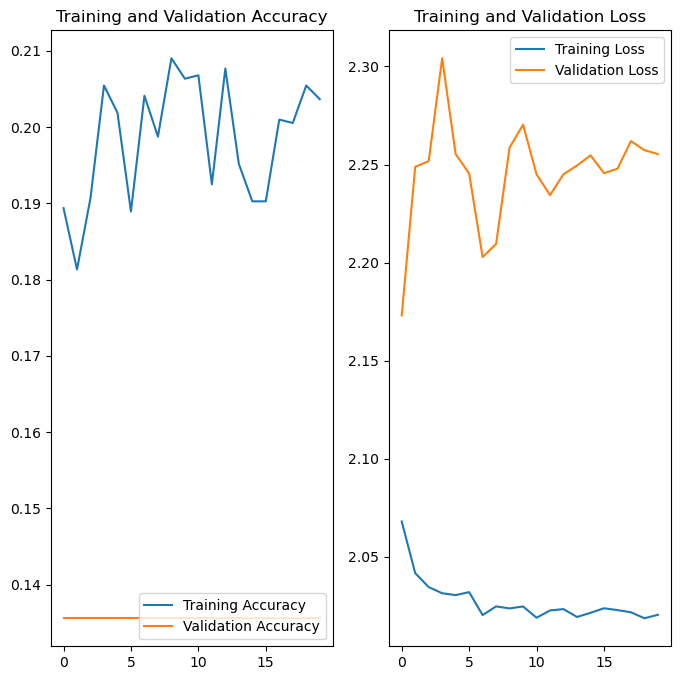

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Model is still overfitting because model has higher accuracies on training data but failing on test data

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

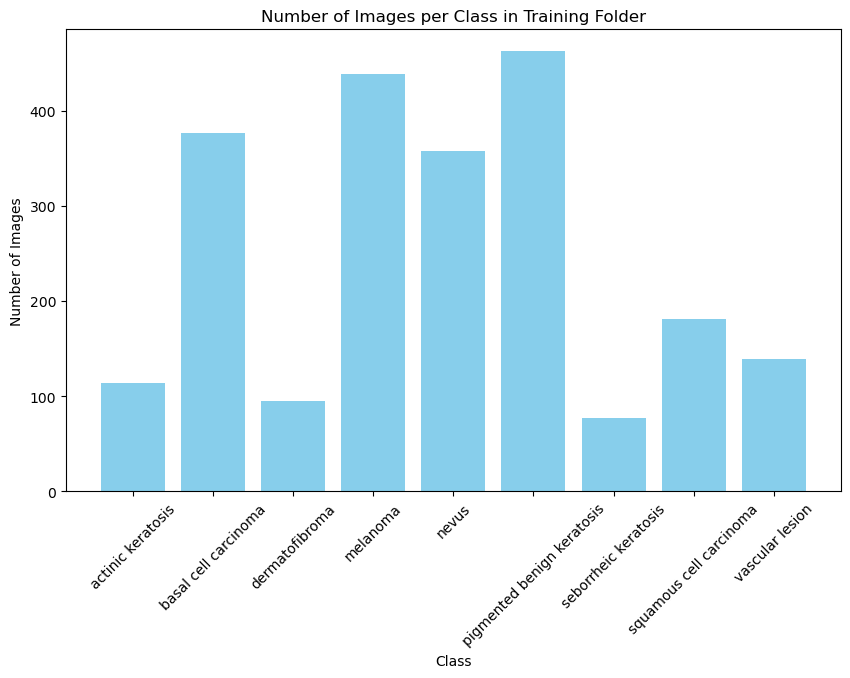

In [25]:
## Your code goes here.
import os
import matplotlib.pyplot as plt

# Path to your training data
training_folder = data_dir_train

# Dictionary to store class names and their corresponding image counts
class_image_counts = {}

# Iterate over each class folder
for class_name in os.listdir(training_folder):
    class_path = os.path.join(training_folder, class_name)
    if os.path.isdir(class_path):
        # Count the number of images in the class folder
        num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_image_counts[class_name] = num_images

# Plotting
classes = list(class_image_counts.keys())
image_counts = list(class_image_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, image_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Folder')
plt.xticks(rotation=45)
plt.show()


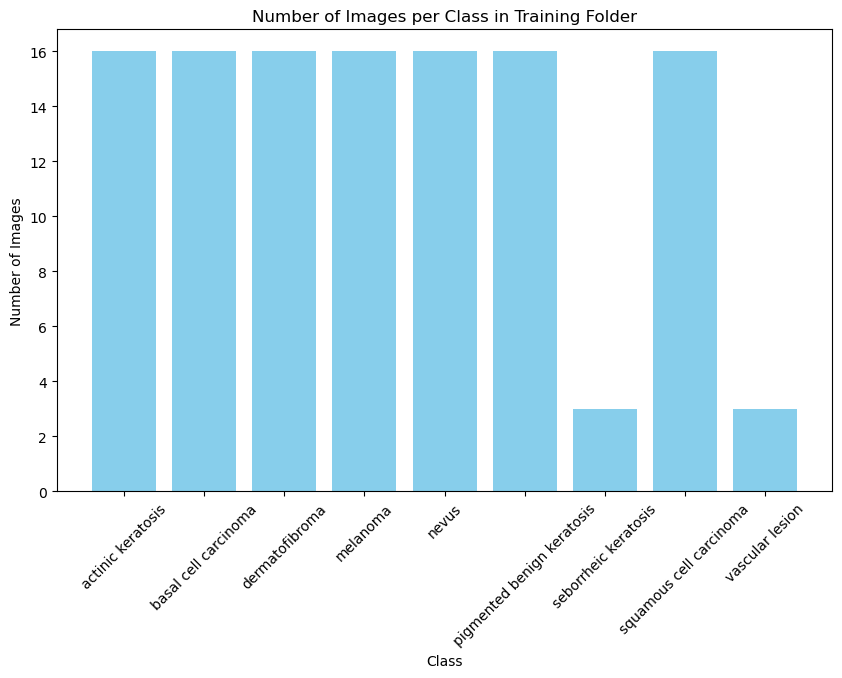

In [26]:
## Your code goes here.
import os
import matplotlib.pyplot as plt

# Path to your training data
training_folder = data_dir_test

# Dictionary to store class names and their corresponding image counts
class_image_counts = {}

# Iterate over each class folder
for class_name in os.listdir(training_folder):
    class_path = os.path.join(training_folder, class_name)
    if os.path.isdir(class_path):
        # Count the number of images in the class folder
        num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_image_counts[class_name] = num_images

# Plotting
classes = list(class_image_counts.keys())
image_counts = list(class_image_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, image_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Folder')
plt.xticks(rotation=45)
plt.show()


In [27]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']


#### - Which class has the least number of samples?



From the Training Sample we have lot of classes with imbalance data.***'actinic keratosis', 'dermatofibroma, 'seborrheic keratosis', 'squamous cell carcinoma' 
 'vascular lesio*** these classes are having least number of samples. Let's make them even by augmentationsn'

#### - Which classes dominate the data in terms proportionate number of samples?

***'basal cell carcinoma', 'melanoma', 'nevus', 'pigmented benign keratosis'*** dominating the data 

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [10]:
data_dir_train

WindowsPath('CNN_assignment/dataset/Train')

In [11]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\Joseph\Desktop\Upgrad


In [12]:
str(data_dir_train)

'CNN_assignment\\dataset\\Train'

In [17]:
import os
import Augmentor

# Correctly set your dataset path
path_to_training_dataset = "CNN_assignment/dataset/Train"

# Assuming `class_names` is a list of your class directories
class_names = os.listdir(path_to_training_dataset)

for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    print(class_path)
    
    # Initialize the Augmentor pipeline with the correct class path
    p = Augmentor.Pipeline(class_path)
    
    # Apply augmentations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    # Sample 500 augmented images
    p.sample(500)## We are adding 500 samples per class to make sure that none of the classes are sparse.

CNN_assignment/dataset/Train\actinic keratosis
Initialised with 114 image(s) found.
Output directory set to CNN_assignment/dataset/Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1BE934646E0>: 100%|█| 500/500 [00:06<00:


CNN_assignment/dataset/Train\basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to CNN_assignment/dataset/Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BE91F2BB60>: 100%|█| 500/500 [00:06<00:00, 76.13 Samples/


CNN_assignment/dataset/Train\dermatofibroma
Initialised with 95 image(s) found.
Output directory set to CNN_assignment/dataset/Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BE8F013AA0>: 100%|█| 500/500 [00:06<00:00, 72.36 Samples/


CNN_assignment/dataset/Train\melanoma
Initialised with 438 image(s) found.
Output directory set to CNN_assignment/dataset/Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1BE9000FE60>: 100%|█| 500/500 [00:31<00:00, 15.99 Samples


CNN_assignment/dataset/Train\nevus
Initialised with 357 image(s) found.
Output directory set to CNN_assignment/dataset/Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1BE93494E00>: 100%|█| 500/500 [00:35<00:


CNN_assignment/dataset/Train\pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to CNN_assignment/dataset/Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1BE9246BE90>: 100%|█| 500/500 [00:06<00:


CNN_assignment/dataset/Train\seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to CNN_assignment/dataset/Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1BE8FE998E0>: 100%|█| 500/500 [00:15<00:00, 32.97 Samples


CNN_assignment/dataset/Train\squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to CNN_assignment/dataset/Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BE924FB320>: 100%|█| 500/500 [00:05<00:00, 84.87 Samples/


CNN_assignment/dataset/Train\vascular lesion
Initialised with 139 image(s) found.
Output directory set to CNN_assignment/dataset/Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1BE8FC3CE30>: 100%|█| 500/500 [00:07<00:00, 64.98 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [18]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [20]:
import glob

In [22]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1794a255-7e45-4ef8-9d7c-701ed29a91ba.jpg',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4545e197-2103-4da0-b660-89694fbf2a05.jpg',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_738a4434-2d94-4b85-b818-52a3bc3c66c6.jpg',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_81bc581e-dfab-470a-bd41-d0b9b9778993.jpg',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_97a9e5bf-3e62-4966-8ee8-f9934f424974.jpg',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_4fb58858-dbf3-48f1-ae57-9b58cf619de1.jpg',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_9d47105

In [24]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [26]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [28]:
dataframe_dict_new

{'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1794a255-7e45-4ef8-9d7c-701ed29a91ba.jpg': 'actinic keratosis',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4545e197-2103-4da0-b660-89694fbf2a05.jpg': 'actinic keratosis',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_738a4434-2d94-4b85-b818-52a3bc3c66c6.jpg': 'actinic keratosis',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_81bc581e-dfab-470a-bd41-d0b9b9778993.jpg': 'actinic keratosis',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_97a9e5bf-3e62-4966-8ee8-f9934f424974.jpg': 'actinic keratosis',
 'CNN_assignment\\dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_4fb58858-dbf3-48f1-ae57-9b58cf619de1.jpg': 'actini

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label']))

SyntaxError: unmatched ')' (3713028058.py, line 1)

In [32]:
df2

,Path,Label
0,CNN_assignment\dataset\Train\actinic keratosis...,actinic keratosis
1,CNN_assignment\dataset\Train\actinic keratosis...,actinic keratosis
2,CNN_assignment\dataset\Train\actinic keratosis...,actinic keratosis
3,CNN_assignment\dataset\Train\actinic keratosis...,actinic keratosis
4,CNN_assignment\dataset\Train\actinic keratosis...,actinic keratosis
...,...,...
4495,CNN_assignment\dataset\Train\vascular lesion\o...,vascular lesion
4496,CNN_assignment\dataset\Train\vascular lesion\o...,vascular lesion
4497,CNN_assignment\dataset\Train\vascular lesion\o...,vascular lesion
4498,CNN_assignment\dataset\Train\vascular lesion\o...,vascular lesion


In [33]:
df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

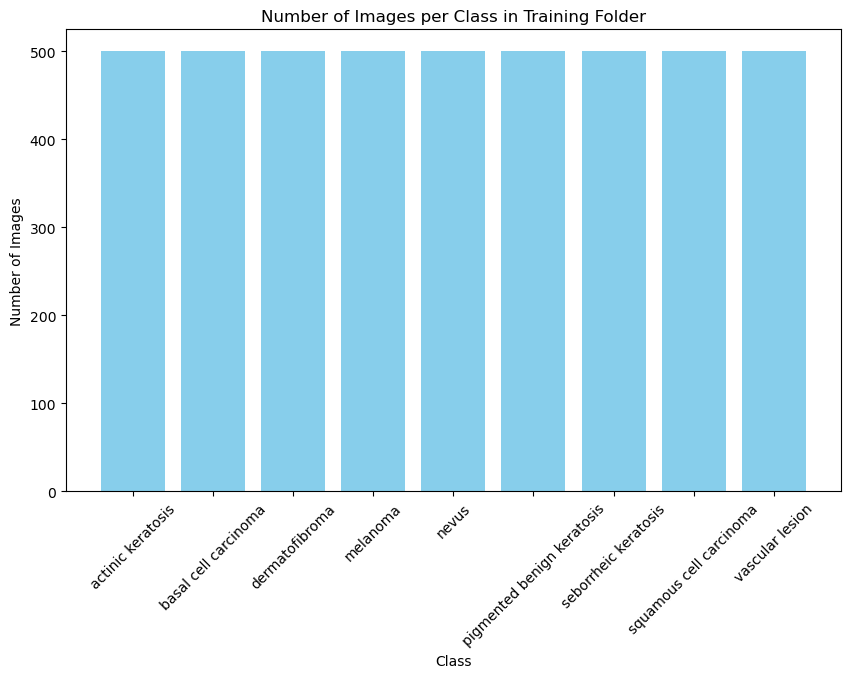

In [11]:
import os
import matplotlib.pyplot as plt

# Path to your training data
training_folder = "CNN_assignment/dataset/Balanced_data"

# Dictionary to store class names and their corresponding image counts
class_image_counts = {}

# Iterate over each class folder
for class_name in os.listdir(training_folder):
    class_path = os.path.join(training_folder, class_name)
    if os.path.isdir(class_path):
        # Count the number of images in the class folder
        num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_image_counts[class_name] = num_images

# Plotting
classes = list(class_image_counts.keys())
image_counts = list(class_image_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, image_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Folder')
plt.xticks(rotation=45)
plt.show()


#### **Todo**: Train the model on the data created using Augmentor

In [12]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [13]:
import os
import shutil

# Paths to your dataset folders
path_to_training_dataset = "CNN_assignment/dataset/Train"
path_to_output_folder = "CNN_assignment/dataset/Output"
path_to_new_folder = "CNN_assignment/dataset/Balanced_data"

# Create the new folder if it doesn't exist
os.makedirs(path_to_new_folder, exist_ok=True)

# Get the list of class names (assuming each class has a folder in both Train and Output)
class_names = os.listdir(path_to_training_dataset)

# for class_name in class_names:
#     class_train_path = os.path.join(path_to_training_dataset, class_name)
#     class_output_path = os.path.join(class_train_path, "Output")
#     new_class_path = os.path.join(path_to_new_folder, class_name)

#     # Create a new class folder in the new directory
#     os.makedirs(new_class_path, exist_ok=True)

#     # Copy images from the training class folder to the new class folder
#     # if os.path.exists(class_train_path):
#     #     for image_name in os.listdir(class_train_path):
#     #         src_image_path = os.path.join(class_train_path, image_name)
#     #         dest_image_path = os.path.join(new_class_path, image_name)
#     #         if os.path.isfile(src_image_path):  # Ensure it's a file
#     #             shutil.copy(src_image_path, dest_image_path)

#     # Copy images from the output class folder to the new class folder
#     if os.path.exists(class_output_path):
#         for image_name in os.listdir(class_output_path):
#             src_image_path = os.path.join(class_output_path, image_name)
#             dest_image_path = os.path.join(new_class_path, image_name)
#             if os.path.isfile(src_image_path):  # Ensure it's a file
#                 shutil.copy(src_image_path, dest_image_path)

print("Images successfully copied to the new folder structure.")


Images successfully copied to the new folder structure.


In [14]:
data_dir_train=path_to_new_folder
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical',
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical',
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [16]:
## your code goes here
from tensorflow.keras import layers, models

# Normalize pixel values to be in the range [0, 1]
normalization_layer = layers.Rescaling(1./255)

# Apply the normalization layer to the datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Define the CNN model
model =keras.Sequential([
    keras.Input(shape=(180, 180, 3)),
    keras.layers.Conv2D(filters=32, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=128, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=3),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(9, activation="softmax")
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [17]:
## your code goes here
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored quantity
)

#### **Todo:**  Train your model

In [19]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - categorical_accuracy: 0.2026 - loss: 2.8272 - val_categorical_accuracy: 0.3378 - val_loss: 1.7335
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.3573 - loss: 1.6686 - val_categorical_accuracy: 0.3256 - val_loss: 1.6577
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - categorical_accuracy: 0.4106 - loss: 1.5581 - val_categorical_accuracy: 0.4722 - val_loss: 1.4549
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.5170 - loss: 1.3467 - val_categorical_accuracy: 0.4800 - val_loss: 1.3814
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - categorical_accuracy: 0.5476 - loss: 1.2554 - val_categorical_accuracy: 0.5744 - val_loss: 1.2174
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - categorical_accuracy: 0.6485 - loss: 1.0040 - val_categorical_accuracy: 0.6678 - val_loss: 0.9659
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - categorical_accuracy: 0.689

#### **Todo:**  Visualize the model results

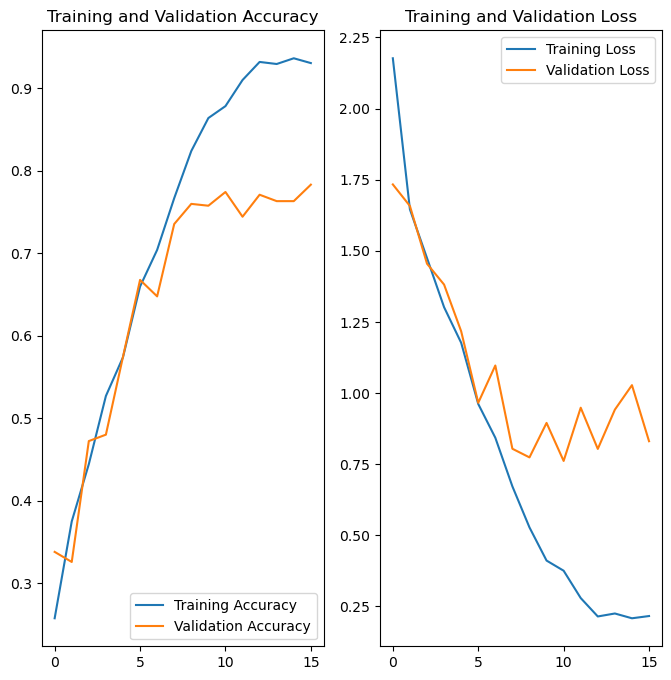

In [21]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes, The augmentation we added to have balenced classes improved our model and reduced overfitting